In [16]:
# !pip install statsmodels
# !pip install seaborn

In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


In [18]:
# Function to load and merge datasets
def merge_csv_files_and_add_columns(directory_path):
    # Initialize an empty list to store individual DataFrames
    df_list = []

    # Iterate through files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            # Read each CSV file into a DataFrame
            file_df = pd.read_csv(os.path.join(directory_path, filename))

            # Initialize the 'event' column to 0 by default
            file_df['event'] = 0

            # Check conditions based on the presence of specific numbers in the filename
            if '25' in filename:
                file_df['event'] = 1
            elif '24' in filename:
                file_df['event'] = 0
            elif '18' in filename:
                file_df['event'] = -1
            elif '13' in filename:
                file_df['event'] = -2

            # Add 'city' column based on the presence of 'Barcelona' in the filename
            file_df['barcelona'] = 1 if 'Barcelona' in filename else 0

            # Append the DataFrame to the list
            df_list.append(file_df)

    # Concatenate all DataFrames in the list
    df = pd.concat(df_list, ignore_index=True)

    return df

# Specify the directory path containing the CSV files
directory_path = r'C:\Users\bakwe\Documents\GitHub\Git extra\Bookings\Scraped_data'

# Call the function to merge CSV files and add columns
df = merge_csv_files_and_add_columns(directory_path)

# Now, 'result_df' contains the combined data with 'city' and 'event' columns added
# based on the specified conditions.


In [19]:
df.shape

(3205, 10)

In [20]:
df.head()

,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,event,barcelona
0,Barco El Marques,"8,3","a 5,5 km del centro",NaN,€ 435,https://www.booking.com/hotel/es/barco-el-marq...,4 de 5,Barco El Marques es un alojamiento con terraza...,-2,1
1,Sonder Casa Luz,"8,4",a 450 m del centro,NaN,€ 670,https://www.booking.com/hotel/es/casa-luz-barc...,3 de 5,El Sonder Casa Luz se encuentra en Barcelona y...,-2,1
2,QUIET ROOM IN THE CITY CENTER,"8,7","a 1,9 km del centro",NaN,€ 220,https://www.booking.com/hotel/es/quiet-room-in...,3 de 5,QUIET ROOM IN THE CITY CENTER se encuentra en ...,-2,1
3,Acta Voraport,"7,4","a 2,9 km del centro",NaN,€ 432,https://www.booking.com/hotel/es/acta-voraport...,4 de 5,"Acta Voraport está en Barcelona, a menos de 1 ...",-2,1
4,Hotel Market,"8,5","a 1,2 km del centro",NaN,€ 372,https://www.booking.com/hotel/es/market.es.htm...,4 de 5,"El Hotel Market se encuentra en Barcelona, jun...",-2,1


## EDA and Data Cleaning

In [21]:
# First, count the occurrences of each value in the 'Hotels' column
hotel_counts = df['Hotels'].value_counts()

# Then, create a new DataFrame containing only rows with 'Hotels' values that appear 4 times (basically, in every period we consider)
df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 4].index)]

# Finally, print the count of 'Hotels' values
print(df['Hotels'].value_counts())


Hotels
Hotel Market                                                                                                               4
Rest Valencia                                                                                                              4
Original Domino House                                                                                                      4
VALENCIA SUITS YOU Centro Histórico, Establecimiento Automatizado-Fast Auto Check in&Out, Solo para Adultos-Adults only    4
Hotel Valencia Center                                                                                                      4
                                                                                                                          ..
HG City Suites Barcelona                                                                                                   4
Ikonik Ramblas                                                                                                        

In [22]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit and convert to numeric
df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')

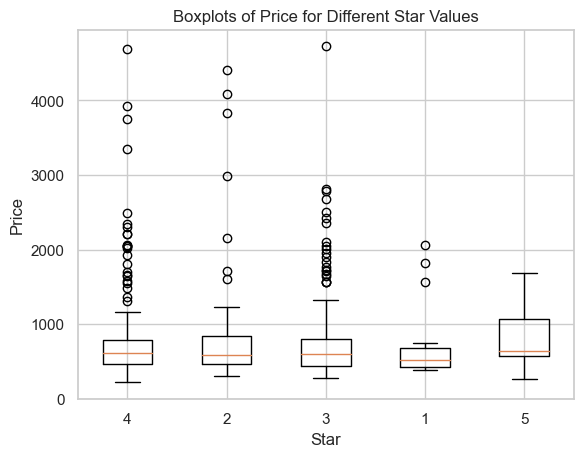

In [23]:
# Group the DataFrame by the 'Star' column and create boxplots for each group
plt.boxplot([df['Price'][df['Star'] == star] for star in df['Star'].unique()], 
            labels=df['Star'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

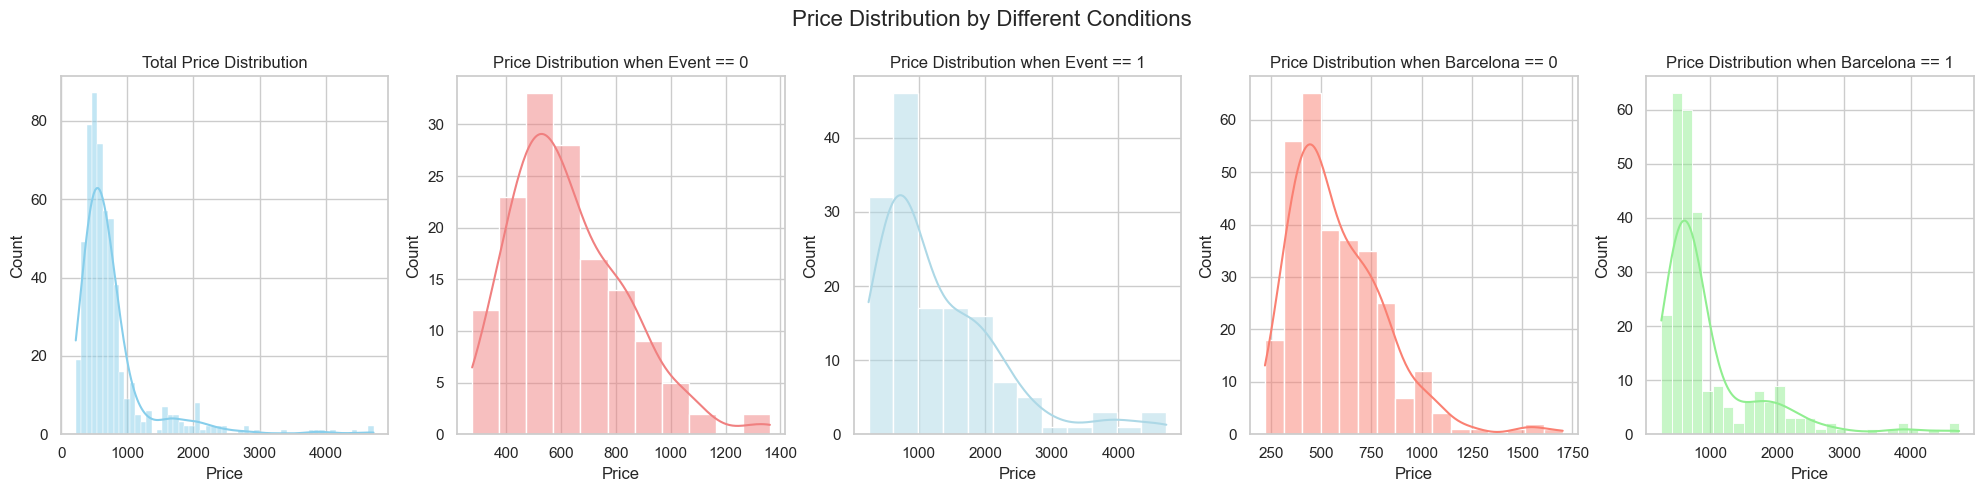

In [24]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and define subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot the distribution of 'Price' for all observations
sns.histplot(df['Price'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Total Price Distribution')

# Create a separate plot for 'event' == 0
sns.histplot(df[df['event'] == 0]['Price'], ax=axes[1], kde=True, color='lightcoral')
axes[1].set_title('Price Distribution when Event == 0')

# Create a separate plot for 'event' == 1
sns.histplot(df[df['event'] == 1]['Price'], ax=axes[2], kde=True, color='lightblue')
axes[2].set_title('Price Distribution when Event == 1')

# Create a separate plot for 'barcelona' == 0
sns.histplot(df[df['barcelona'] == 0]['Price'], ax=axes[3], kde=True, color='salmon')
axes[3].set_title('Price Distribution when Barcelona == 0')

# Create a separate plot for 'barcelona' == 1
sns.histplot(df[df['barcelona'] == 1]['Price'], ax=axes[4], kde=True, color='lightgreen')
axes[4].set_title('Price Distribution when Barcelona == 1')

# Add a title to the overall figure
fig.suptitle('Price Distribution by Different Conditions', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the individual plots
plt.show()


## Common Trend

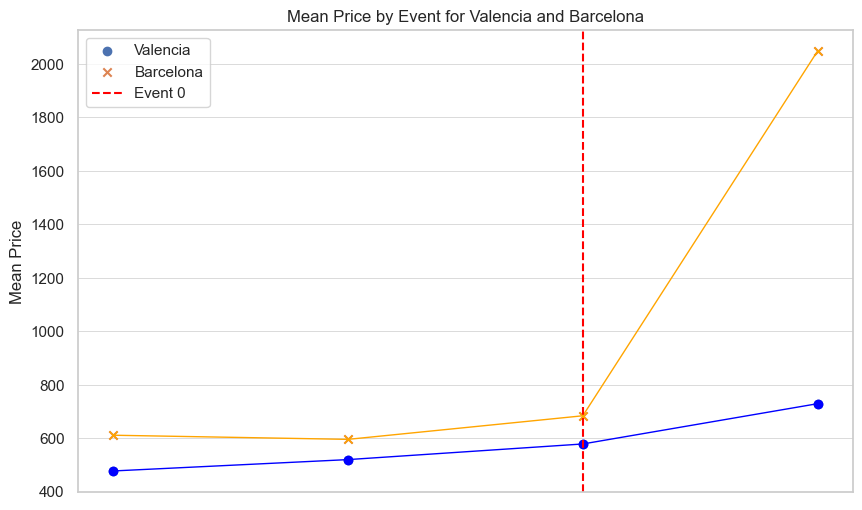

In [25]:
# Calculate the mean Price for each unique event and Barcelona combination
df_means = df.groupby(['event', 'barcelona'])['Price'].mean().reset_index()

# Filter the DataFrame for 'barcelona' == 0 and 'barcelona' == 1
barcelona_0 = df_means[df_means['barcelona'] == 0]
barcelona_1 = df_means[df_means['barcelona'] == 1]

# Create the plot with less bold labels and lines
plt.figure(figsize=(10, 6))
plt.scatter(x='event', y='Price', data=barcelona_0, label='Valencia', marker='o')
plt.scatter(x='event', y='Price', data=barcelona_1, label='Barcelona', marker='x')
plt.plot(barcelona_0['event'], barcelona_0['Price'], linestyle='-', marker='o', color='blue', lw=1)
plt.plot(barcelona_1['event'], barcelona_1['Price'], linestyle='-', marker='x', color='orange', lw=1)
plt.axvline(x=0, color='red', linestyle='--', label='Event 0')  # Add vertical line at 'event' == 0
plt.xlabel('')
plt.ylabel('Mean Price', fontweight='light')  # Less bold font for the y-axis label
plt.title('Mean Price by Event for Valencia and Barcelona', fontweight='light')  # Less bold font for the title
plt.legend()
plt.grid(True, linewidth=0.5)  # Thin grid lines

# Remove x-axis labels
plt.xticks([])

plt.show()

## Regressions

In [26]:
# Subset rows where 'event' is equal to 1 or 0
df = df[df['event'].isin([1, 0])]

In [27]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.544
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              350.1
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                    6.04e-52
Time:                        14:20:46   Log-Likelihood:                         -2393.6
No. Observations:                 294   AIC:                                      4789.
Df Residuals:                     293   BIC:                                      4793.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [28]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.568
Method:                 Least Squares   F-statistic:                              386.9
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                    1.71e-55
Time:                        14:20:46   Log-Likelihood:                         -2385.5
No. Observations:                 294   AIC:                                      4773.
Df Residuals:                     293   BIC:                                      4777.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                              344.8
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                    1.88e-95
Time:                        14:20:46   Log-Likelihood:                         -2286.3
No. Observations:                 294   AIC:                                      4579.
Df Residuals:                     291   BIC:                                      4590.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [30]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
# X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              380.5
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                   5.02e-114
Time:                        14:20:46   Log-Likelihood:                         -2239.8
No. Observations:                 294   AIC:                                      4488.
Df Residuals:                     290   BIC:                                      4502.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------